In [1]:
import Pkg; Pkg.add(["Plots" ,"IterativeSolvers"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false, fmt=:png);
using Printf;
using Interact;
using SparseArrays;
import IterativeSolvers;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

**(follow along: <https://tinyurl.com/gtcse6643lec25>)**

# GMRES

**1.  Review and definition of GMRES**

**2. Implementation of GMRES**

**3. Analysis of GMRES**

## Review: the Arnoldi iteration

**Conceptually**:

$$\large Q_n R_n = K_n(A,b)$$

**In practice:**

$$\begin{aligned}
{\large A Q_n} &{\large = Q_{n+1} \tilde H_n,}\\
Q_1 &= \begin{bmatrix} \frac{b}{\|b\|} \end{bmatrix}, \\
Q_k &\in \mathbb{C}^{m \times k}, \quad Q_k^* Q_k = I,  \\
\tilde{H}_k &\in \mathbb{C}^{k + 1 \times k} \quad \text{upper hessenberg}
\end{aligned}
$$

In [4]:
function arnoldi(A, b, n)
    m = size(A)[1]
    @assert n ≤ m
    Q = zeros(eltype(A), m, n+1)
    H̃ = zeros(eltype(A), n+1, n)
    Q[:,1] = b / norm(b)
    for j in 1:n
        v = A * Q[:,j]
        for i in 1:j # modified Gram-Schmidt
            H̃[i,j] = Q[:,i]' * v
            v -= Q[:,i] * H̃[i,j]
        end
        H̃[j+1,j] = norm(v)
        Q[:,j+1] = v / H̃[j+1,j]
    end
    return Q, H̃
end

arnoldi (generic function with 1 method)

- $Q_n$ is an orthonormal basis for $\mathcal{K}_n(A,b)$

## Defining GMRES (Generalized Minimal Residual Method)

$$\large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \| b - A x \|_2$$

- $x_n$ is defined to **minimize the $\ell_2$ norm of the residual $r = b - Ax$** in the Krylov subspace $\mathcal{K}_n(A,b)$

- This solution is defined for **general matrices** (compare to MINRES, another method for normal matrices)

### Computing GMRES via the Arnoldi Iteration

$$\large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \| b - A x \|_2$$

$$\large x \in \mathcal{K}_n(A,b) \quad \Leftrightarrow \quad x = Q_n y \quad \text{for some } y \in \mathbb{C}^{n}$$

$\Rightarrow$ an algorithm is:


1. Compute

$$\large y_n = \mathop{\arg\min}_{y\in\mathbb{C}^n} \| b - A Q_n y \|_2.$$

2. Compute

$$\large x_n = Q_n y_n.$$

### Using the Arnoldi iteration identity $A Q_n = Q_{n+1} \tilde{H}_n$

$$\large y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \| b - A Q_n y \|_2
\quad \Leftrightarrow \quad
y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \| b - Q_{n+1} \tilde{H}_n y \|_2
$$

### Using the property $q_0 = \frac{b}{\|b\|}$

(reorganized as $b = q_0 \|b\|$)

$$
\large y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \| b - Q_{n+1} \tilde{H}_n y \|_2
\quad \Leftrightarrow \quad
y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \| Q_{n+1} ( e_1\|b\| - \tilde{H}_n y) \|_2
$$

### Using the isometry property of orthonormal bases

$$
\large y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \| Q_{n+1} ( e_1\|b\| - \tilde{H}_n y) \|_2
\quad \Leftrightarrow \quad
y_n = \mathop{\arg\min}_{y\in\mathbb{C}} \big\| e_1\|b\| - \tilde{H}_n y \big\|_2
$$

**Q:** How much work per iteration at iteration $n$?

- one matvec $W_{\text{matvec}}$
- Arnoldi iteration work ($(n+1)$ vector dot products, $n$ vector `axpy`s) = $O(mn)$
- one $(n+1) \times n$ least squares problem with an upper Hessenberg matrix = ???

## GMRES in practice

### Observation 1: QR factorization of an upper Hessenberg matrix

**Orthonormal triangularization** by reflector or **Givens rotation** is accomplished for each vector by one $2 \times 2$ transformation,

$$G_{\theta} = \begin{bmatrix} \cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta) \end{bmatrix},$$

encoded as a **rotation angle $\theta_n$** $\Rightarrow$ QR factorization in $O(n^2)$ work (vs. $O(n^3)$ in general)

Generate the Givens rotations, apply them to $H$ and the rhs of the least squares problem, store the $\theta$s

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/gmres.gif")
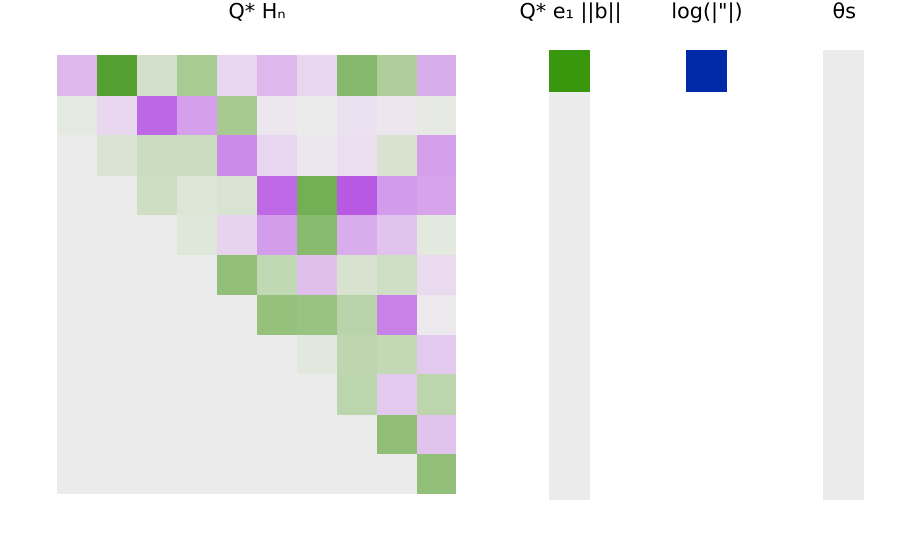

In [5]:
n = 10
H = Matrix(UpperHessenberg(randn(n+1,n)))
for i in 1:n
    H[i+1,i] = abs(H[i+1,i])
end
scale = maximum(abs.(H))
b = zeros(n+1)
b[1] = 1.
θs = zeros(n+1)
p = imshow(H, clim=(-scale,scale), colorbar=false, xlim=(0,n+1), ylim=(0,n+2), title="Q* Hₙ")
q = imshow([b;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="Q* e₁ ||b||")
t = imshowlog([b;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="log(|\"|)")
s = imshow([θs;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="θs")
anim = Animation()
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
for k in 1:n
    p = imshow(H, clim=(-scale,scale), colorbar=false, xlim=(0,n+1), ylim=(0,n+2), title="Q* Hₙ")
    plot!(p, [k-0.5,k+0.5,k+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=1)
    q = imshow([b;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="Q* e₁ ||b||")
    t = imshowlog([b;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="log(|\"|)")
    s = imshow([θs;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="θs")
    frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
    α = H[k,k]
    β = H[k+1,k]
    θ = atan(β, α)
    θs[k] = θ
    p = imshow(H, clim=(-scale,scale), colorbar=false, xlim=(0,n+1), ylim=(0,n+2), title="Q* Hₙ")
    plot!(p, [k-0.5,k+0.5,k+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=1)
    q = imshow([b;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="Q* e₁ ||b||")
    t = imshowlog([b;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="log(|\"|)")
    s = imshow([θs;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="θs")
    plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
    frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
    c = cos(θ)
    s = sin(θ)
    G = [c s; -s c]
    H[k:k+1,:] = G * H[k:k+1,:]
    b[k:k+1,:] = G * b[k:k+1,:]
    p = imshow(H, clim=(-scale,scale), colorbar=false, xlim=(0,n+1), ylim=(0,n+2), title="Q* Hₙ")
    plot!(p, [k-0.5,n+0.5,n+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=7)
    q = imshow([b;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="Q* e₁ ||b||")
    plot!(q, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=7)
    t = imshowlog([b;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="log(|\"|)")
    s = imshow([θs;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="θs")
    plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
    frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
end
p = imshow(H, clim=(-scale,scale), colorbar=false, xlim=(0,n+1), ylim=(0,n+2), title="Q* Hₙ")
q = imshow([b;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="Q* e₁ ||b||")
t = imshowlog([b;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="log(|\"|)")
s = imshow([θs;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,n+2), title="θs")
plot!(q, [0.5,1.5,1.5,0.5,0.5], [n+0.5,n+0.5,n+1.5,n+1.5,n+0.5], c=7)
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[n/(n+6), 2/(n+6), 2/(n+6), 2/(n+6)])))
gif(anim, "gmres.gif", fps=0.5)

### Observation 2: The final value of $Q^* e_1 \|b\|$ is $\|r_n\|$

This makes it easy to use $\|r_n\| < \epsilon$ as a stopping criterion.

### Observation 3: QR factorization of $\tilde{H}$ can be interleaved with its construction

Construct a new column of $\tilde{H}$, apply the previous Givens rotations, then compute one new Givens rotation and apply it

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/gmres-new.gif")
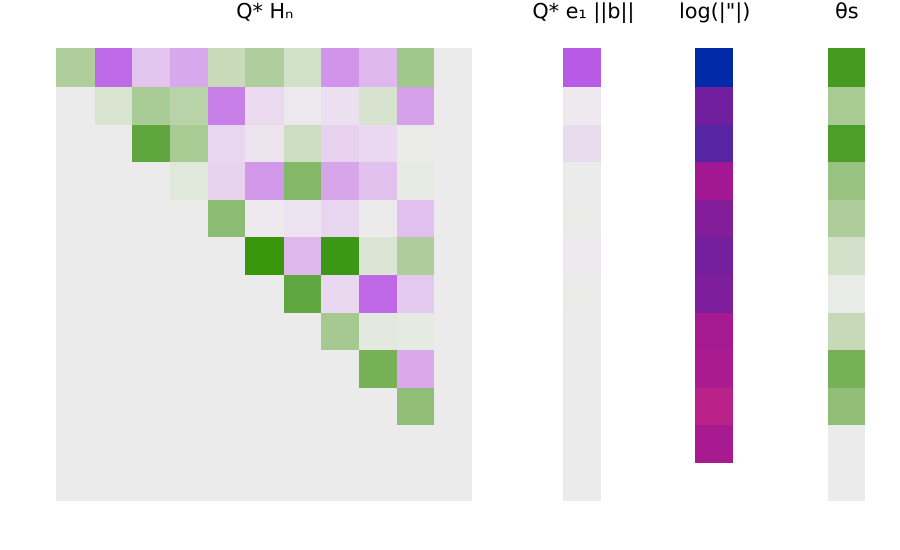

In [6]:
nnew = n + 1
Hnew = zeros(nnew+1, nnew)
Hnew[1:n+1,1:n] = H
bnew = zeros(nnew+1)
bnew[1:n+1] = b
θsnew = zeros(nnew+1)
θsnew[1:n+1] = θs
anim = Animation()
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))

Hnew[:,nnew] = randn(nnew+1)
Hnew[end,end] = abs(Hnew[end,end])
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
plot!(p, [nnew-0.5,nnew+0.5,nnew+0.5,nnew-0.5,nnew-0.5], [0.5,0.5,nnew+1.5,nnew+1.5,0.5], c=1)
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
for k in 1:n
    θ = θs[k]
    p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
    q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
    t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
    s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
    plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
    frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
    c = cos(θ)
    s = sin(θ)
    G = [c s; -s c]
    Hnew[k:k+1,nnew] = G * Hnew[k:k+1,nnew]
    p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
    q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
    t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
    s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
    plot!(p, [nnew-0.5,nnew+0.5,nnew+0.5,nnew-0.5,nnew-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=7)
    plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
    frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
end
k = n + 1
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
plot!(p, [k-0.5,k+0.5,k+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=1)
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
α = Hnew[k,k]
β = Hnew[k+1,k]
θ = atan(β, α)
θs[k] = θ
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
plot!(p, [k-0.5,k+0.5,k+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=1)
plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
c = cos(θ)
s = sin(θ)
G = [c s; -s c]
Hnew[k:k+1,:] = G * Hnew[k:k+1,:]
bnew[k:k+1,:] = G * bnew[k:k+1,:]
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
plot!(s, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+.5,k+.5,k-0.5], c=2)
plot!(p, [k-0.5,nnew+0.5,nnew+0.5,k-0.5,k-0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=7)
plot!(q, [0.5,1.5,1.5,0.5,0.5], [k-0.5,k-0.5,k+1.5,k+1.5,k-0.5], c=7)
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
plot!(q, [0.5,1.5,1.5,0.5,0.5], [nnew+0.5,nnew+0.5,nnew+1.5,nnew+1.5,nnew+0.5], c=7)
frame(anim, plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)])))
gif(anim, "gmres-new.gif", fps=0.5)

### Observation 4: knowing $\|r_n\|$, only solve by backsubstitution once for the final $y_n$

Amortize $O(n^2)$ operations over the previous $n$ iterations

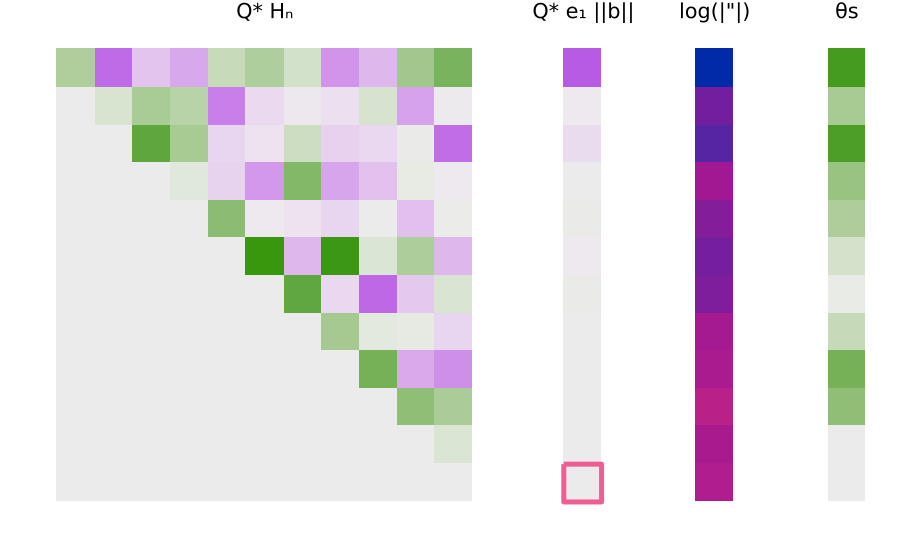

In [7]:
p = imshow(Hnew, clim=(-scale,scale), colorbar=false, xlim=(0,nnew+1), ylim=(0,nnew+2), title="Q* Hₙ")
q = imshow([bnew;;], clim=(-1.0,1.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="Q* e₁ ||b||")
t = imshowlog([bnew;;], clim=(log(eps()),0.0), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="log(|\"|)")
s = imshow([θsnew;;], clim=(-π,π), colorbar=false, xlim=(0,2), ylim=(0,nnew+2), title="θs")
plot!(q, [0.5,1.5,1.5,0.5,0.5], [nnew+0.5,nnew+0.5,nnew+1.5,nnew+1.5,nnew+0.5], c=7)
plot(p,q,t,s, layout=grid(1,4, widths=[nnew/(nnew+6), 2/(nnew+6), 2/(nnew+6), 2/(nnew+6)]))

### Applying observations 1-4

In addition to **matvecs** and **Arnoldi iteration** work, amortized $O(n)$ work per iteration for $n$ iterations of GMRES

The dominant non-matvec work is the $O(mn)$ work in the arnoldi iterations: expensive for large $n$

- Stopping with a fixed maximum value $k$ for $n$ is the GMRES($k$) method (see homework problem)

## Analyzing GMRES convergence

### Convergence is monotonic

Because $\mathcal{K}_n \subseteq \mathcal{K}_{n+1}$,

$$
\large \min_{x\in \mathcal{K}_{n+1}} \|b - A x\|_2 \leq \min_{x\in \mathcal{K}_{n}}  \|b - A x\|_2
$$

### Convergence in at most $m$ iterations

At which point

$$\large A Q_m = Q_m H_m$$

and the least-squares problem becomes a system of equations equivalent to $Ax = b$,

$$\large H_m y = \|b\| e_1.$$

### GMRES and Polynomial Approximation

**Recall: monic polynomials $P^n$**.  To analyze GMRES convergence, we instead use

$$\large P_n = \{\text{polynomials }p\text{ of degree }\leq n\text{ with }p(0) = 1\}.$$

Why?

$x_n \in \mathcal{K}_n \Leftrightarrow x = q_n(A)b$ for $n-1$ degree polynomial $q$ $\Rightarrow$

$$\large r_n = b - A x_n = \underbrace{b - Aq_n(A) b}_{p_n(A)b,\ p_n\in P_n} = \underbrace{(I - Aq_n(A))}_{1 - \lambda q_n(\lambda)} b$$

### GMRES is equivalent to a polynomial minimization problem

$$\large \min_{x \in \mathcal{K}_n(A,b)} \|b - Ax\|_2 \quad=\quad \inf_{p_n \in P_n} \| p_n(A) b \|_2$$

We generally want analysis that doesn't use special properties of $b$, so a useful bound is

$$\large \|r_n\| = \inf_{p_n \in P_n} \| p_n(A) b \|_2 \leq \|b\|_2 \inf_{p_n \in P_n} \| p_n(A) \|_2$$

$$\large \frac{\|r_n\|}{\|b\|} \leq \inf_{p_n \in P_n} \| p_n(A) \|_2$$

### Analyze diagonalizable matrices

We want to understand the quantity

$$\large \inf_{p_n \in P_n} \| p_n(A) \|_2.$$

If we assume $A$ is diagonalizable,

$$\large A = X \Lambda X^{-1},$$

then:

$$\large
\begin{aligned}\inf_{p_n \in P_n} \| p_n(A) \|_2 &= \inf_{p_n \in P_n} \| X p_n(\Lambda) X^{-1} \|_2 \\
&\leq \| X \|_2 \| X^{-1}\|_2 \inf_{p_n \in P_n}\|p_n(\Lambda) \|_2 \\
&= \kappa(X) \inf_{p_n \in P_n} \max_{\lambda \in \Lambda} |p_n(\lambda)|.
\end{aligned}$$


**T&B Theorem 35.2.** At step $n$ of the GMRES iteration of a diagonalizable matrix $A$, the residual $r_n$ satisfies

$$\large \frac{\|r_n\|}{\|b\|} \leq \kappa(X) \inf_{p_n \in P_n} \max_{\lambda \in \Lambda} |p_n(\lambda)|.$$

So we see two factors that can explain convergence:


1. The conditioning of the eigenbasis $X$

2. How small $p_n$ can be on the set of eigenvalues $\Lambda$

### Numerical experiment 1: fix $\Lambda$, vary $\kappa(X)$

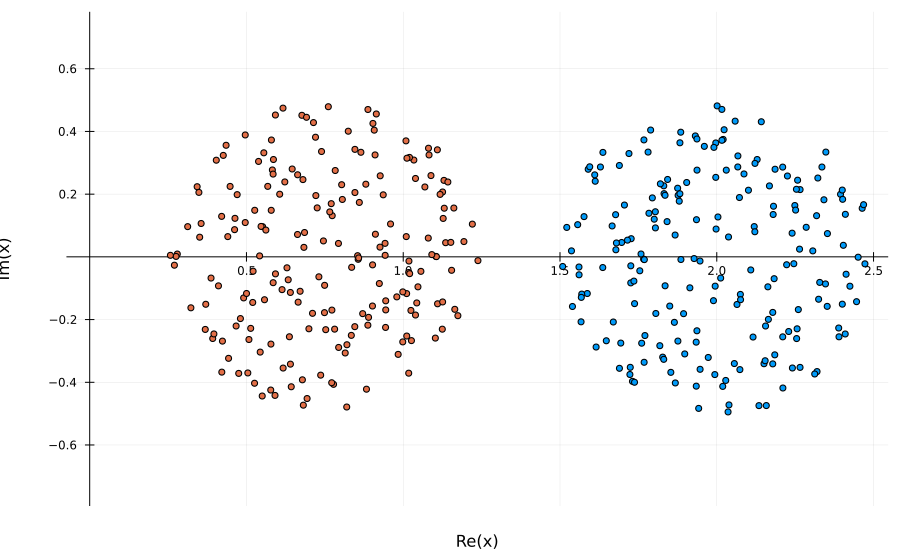

In [8]:
m = 200
Λ₁ = 2 .+ 0.5 * (rand(m) .^ (1/2)) .* exp.(im * rand(m) * 2π)
Λ₂ = 0.75 .+ 0.5 * (rand(m) .^ (1/2)) .* exp.(im * rand(m) * 2π)
plot(Λ₁, st=:scatter, aspect_ratio = :equal, framestyle=:origin)
plot!(Λ₂, st=:scatter, aspect_ratio = :equal, framestyle=:origin)

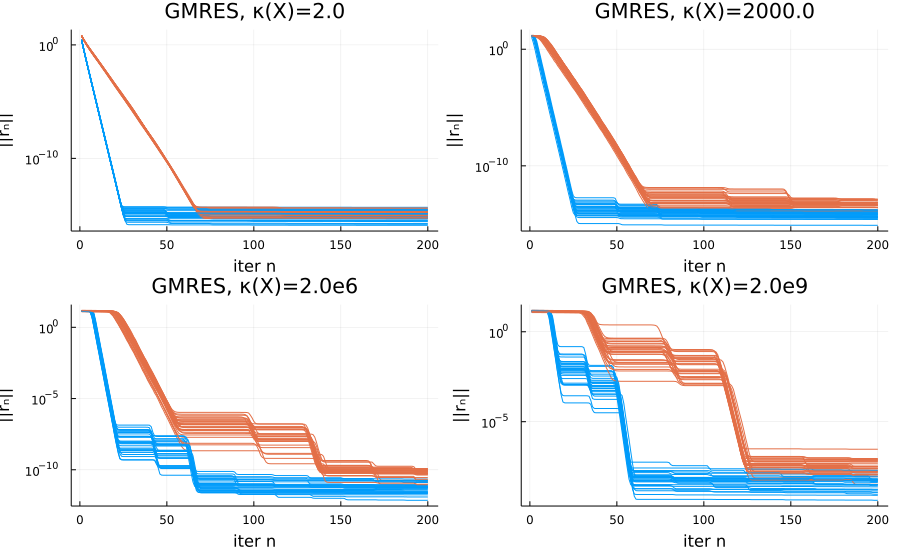

In [9]:
ps = []
n_trials = 30
for κ in [2.e0, 2.e3, 2.e6, 2.e9]
    Σ = LinRange(1, 1/κ, m)
    p = plot(yscale=:log10, xlabel="iter n", ylabel = "||rₙ||", title="GMRES, κ(X)=$κ")
    for i in 1:n_trials
        b = randn(m)
        U = qr(randn(Complex{Float64}, m, m)).Q
        V = qr(randn(Complex{Float64}, m, m)).Q
        X = U * Diagonal(Σ) * V'
        A = X * (Diagonal(Λ₁) / X)
        rs = IterativeSolvers.gmres(A, b; restart=2*m, maxiter=m, log=true, reltol=0)[2][:resnorm]
        plot!(p, 1:m, rs, l=1, c=1)
        b = randn(m)
        U = qr(randn(Complex{Float64}, m, m)).Q
        V = qr(randn(Complex{Float64}, m, m)).Q
        X = U * Diagonal(Σ) * V'
        A = X * (Diagonal(Λ₂) / X)
        rs = IterativeSolvers.gmres(A, b; restart=2*m, maxiter=m, log=true, reltol=0)[2][:resnorm]
        plot!(p, 1:m, rs, l=1, c=2)
    end
    push!(ps, p)
end
plot(ps..., layout=(2,2))

- Ill-conditioned eigenbasis $X$ $\Rightarrow$ long periods of **stagnation**

### Experiment 2: Fix $\kappa(X)$, vary $\Lambda$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/spec-donut.gif")
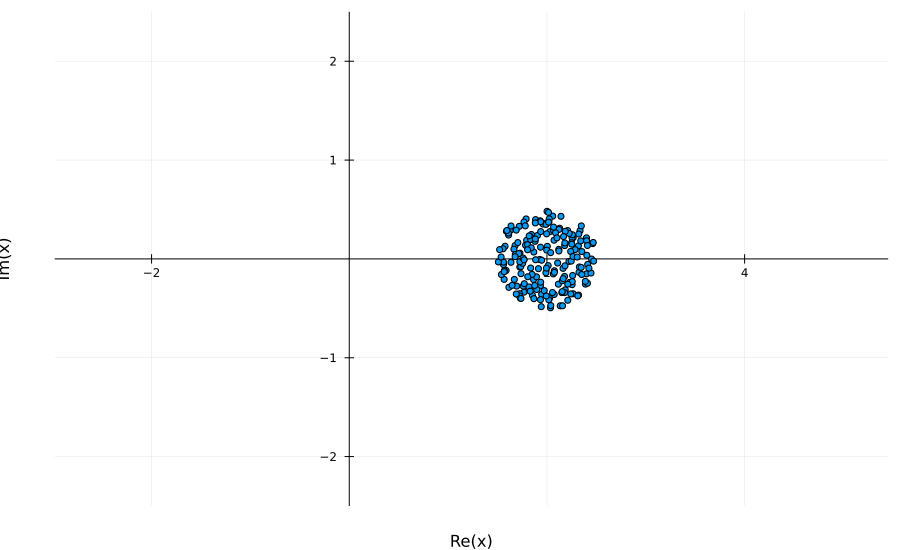

In [10]:
anim = Animation()
for s in LinRange(0,2,100)
    Λ₃ = copy(Λ₁)
    for i in 1:m
        k = i-1 - (m-1)/2
        θ = (k * s * π) / (m - 1)
        Λ₃[i] *= exp(im * θ)
    end
    frame(anim, plot(Λ₃, st=:scatter, ylim=(-2.5,2.5), aspect_ratio = :equal, framestyle=:origin))
end
gif(anim, "spec-donut.gif")

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/conv-donut.gif")
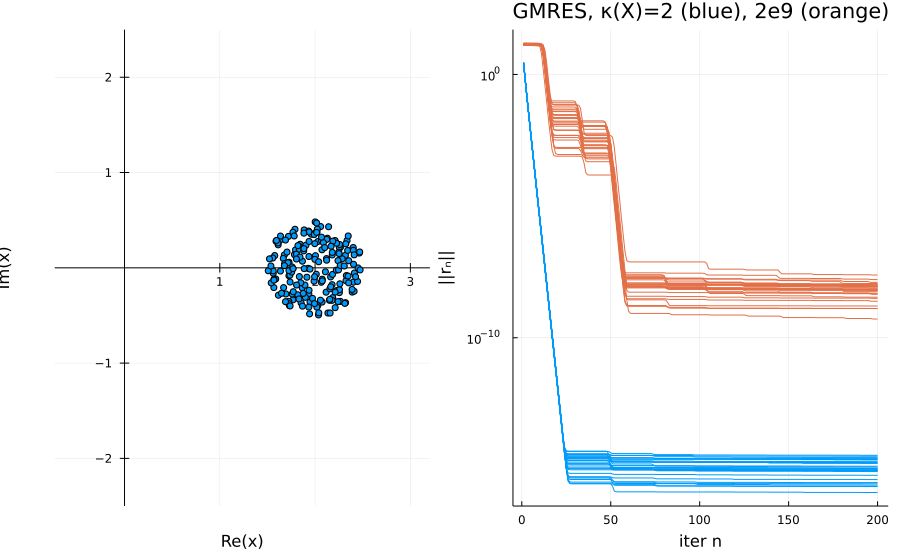

In [11]:

anim = Animation()
for s in LinRange(0,2,100)
    Λ₃ = copy(Λ₁)
    for i in 1:m
        k = i-1 - (m-1)/2
        θ = (k * s * π) / (m - 1)
        Λ₃[i] *= exp(im * θ)
    end
    ps = []
    n_trials = 30
    spectrum = plot(Λ₃, st=:scatter, ylim=(-2.5,2.5), aspect_ratio = :equal, framestyle=:origin)
    p = plot(yscale=:log10, xlabel="iter n", ylabel = "||rₙ||", title="GMRES, κ(X)=2 (blue), 2e9 (orange)")
    for (c,κ) in enumerate([2.e0, 2.e9])
        Σ = LinRange(1, 1/κ, m)
        for i in 1:n_trials
            b = randn(m)
            U = qr(randn(Complex{Float64}, m, m)).Q
            V = qr(randn(Complex{Float64}, m, m)).Q
            X = U * Diagonal(Σ) * V'
            A = X * (Diagonal(Λ₃) / X)
            rs = IterativeSolvers.gmres(A, b; restart=2*m, maxiter=m, log=true, reltol=0)[2][:resnorm]
            plot!(p, 1:m, rs, l=1, c=c)
        end
    end
    frame(anim, plot(spectrum, p, layout=(1,2)))
end
gif(anim, "conv-donut.gif")

- The more $\Lambda$ **encircles the origin**, the larger $\inf_{p_n \in P_n} \max_{\lambda \in \Lambda} |p(\lambda)|$ is.

### Lecture exercise

**T&B Exercise 35.2(b)** Let $A$ be a matrix, not necessarily normal, whose spectrum $\Lambda(A)$ is a set whose convex hull contains 0 in its interior.  Show that there is no $p_1 \in P_1$ such that $\|p_1(A)\| < 1$.

## GMRES: additional results

(More detail in **CSE / MATH 6644: Iterative Methods**)

(Great book with a free online edition from the author: Yousef Saad, _Iterative Methods for Sparse Linear Systems_.)

### One positive result

**Saad Corollary 6.33**  Suppose the spectrum $\Lambda$ is contained in an oriented ellipse centered on the real line at $c$ with real axis length $a$ and focal length $d$.  Then

$$\inf_{p_n \in P_n} \max_{\lambda \in \Lambda} |p_n(\lambda)| \leq \left(\frac{a + \sqrt{a^2 - d^2}}{c + \sqrt{c^2 - d^2}}\right)^n$$

The quantity on the right describes a bound on the convergence rate.

### One negative result

Let $\Lambda$ be any set of $m$ eigenvalues and let $r_1 \geq r_2 \dots \geq r_m = 0$ be any positive, non-increasing sequence terminating in zero.  Then there is a matrix $A$ with spectrum $\Lambda$ and a vector $b$ such that $r$ is the convergence history of GMRES.